In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import sys 
import utils
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 16
lr = 0.0001
opt = tf.keras.optimizers.Adam(lr)
tfrecords_read_dir = '/home/kevinteng/Desktop/BRATS_stack/tfrecords/'

---

# Helper Functions

In [3]:
def dicesq(y_true, y_pred):
    '''
    Modified dice coefficient as refer to: https://arxiv.org/abs/1606.04797
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    :return: Modified dice coefficient
    '''
    nmr = 2*tf.reduce_sum(y_true*y_pred)
    dnmr = tf.reduce_sum(y_true**2) + tf.reduce_sum(y_pred**2) + tf.keras.backend.epsilon()
    return (nmr / dnmr)

def dicesq_loss(y_true, y_pred):
    '''
    Modified dice coefficient loss
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    '''
    return 1- dicesq(y_true, y_pred)

def dice_coef(y_true, y_pred):
    '''
    Dice coefficient for tensorflow
    '''
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + tf.keras.backend.epsilon()) / \
(tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + tf.keras.backend.epsilon())

def dice_coe(target, output, axis=(1, 2, 3), smooth=1e-5):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity
    of two batch of data, usually be used for binary image segmentation
    i.e. labels are binary. The coefficient between 0 to 1, 1 means totally match.

    Parameters
    -----------
    output : Tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    target : Tensor
        The target distribution, format the same with `output`.
    loss_type : str
        ``jaccard`` or ``sorensen``, default is ``jaccard``.
    axis : tuple of int
        All dimensions are reduced, default ``[1,2,3]``.
    smooth : float
        This small value will be added to the numerator and denominator.
            - If both output and target are empty, it makes sure dice is 1.
            - If either output or target are empty (all pixels are background), dice = ```smooth/(small_value + smooth)``, then if smooth is very small, dice close to 0 (even the image values lower than the threshold), so in this case, higher smooth can have a higher dice.

    Examples
    ---------
    >>> import tensorlayer as tl
    >>> outputs = tl.act.pixel_wise_softmax(outputs)
    >>> dice_loss = 1 - tl.cost.dice_coe(outputs, y_)

    References
    -----------
    - `Wiki-Dice <https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient>`__
    https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/cost.html
    """
    inse = tf.reduce_sum(output * target, axis=axis)
    l = tf.reduce_sum(output * output, axis=axis)
    r = tf.reduce_sum(target * target, axis=axis)
    dice = (2. * inse + smooth) / (l + r + smooth)
    dice = tf.reduce_mean(dice)
    return dice

def dice_coef_loss(y_true, y_pred):
    '''
    Dice coefficient loss for IOU
    '''
    return 1-dice_coe(y_true, y_pred)

def plot_comparison(input_img, caption, n_row=1, n_col=2, figsize=(10, 10), cmap = 'gray'):
    '''
    Plot comparison of multiple image but only in column wise!
    :param input_img: Input image list
    :param caption: Input caption list
    :param IMG_SIZE: Image size
    :param n_row: Number of row is 1 by DEFAULT
    :param n_col: Number of columns
    :param figsize: Figure size during plotting
    :return: Plot of (n_row, n_col)
    '''
    print()
    assert len(caption) == len(input_img), "Caption length and input image length does not match"
    assert len(input_img) == n_col, "Error of input images or number of columns!"

    fig, axes = plt.subplots(n_row, n_col, figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.7)

    for i in range(n_col):
        axes[i].imshow(np.squeeze(input_img[i]), cmap= cmap)
        axes[i].set_xlabel(caption[i])
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    plt.tight_layout()
    plt.show()

----

# Model

In [4]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from coord_conv import CoordConv

def conv_block(x_in, filters, batch_norm = False, kernel_size=(3,3)):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm==True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    if batch_norm==True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def coordconv_block(x_in, x_dim, y_dim, filters, batch_norm = False, kernel_size=(3,3), with_r = False):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm==True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = CoordConv(x_dim, y_dim, with_r, filters, kernel_size, padding='same')(x)
    if batch_norm==True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv_2d(x_in, filters, batch_norm = False, kernel_size=(3,3),acti ='relu'):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm==True:
        x=BatchNormalization()(x)
    x= Activation(acti)(x)
    return x
    
def pool(x_in, pool_size=(2, 2), type='Max'):
    if type=='Max':
        p = MaxPooling2D(pool_size)(x_in)
    return p

def up(x_in, filters, merge, batch_norm = False, size=(2,2)):
    u = UpSampling2D(size)(x_in)
    conv = conv_2d(u, filters, batch_norm)
    concat = tf.concat([merge, conv],axis=-1)
    return concat
    
def Unet_model(input_layer):
    #downsampling
    conv1 = coordconv_block(input_layer, x_dim=240, y_dim=240, filters=64)
    pool1 = pool(conv1)
    
    conv2 = conv_block(pool1, filters=128)
    pool2 = pool(conv2)
    
    conv3 = conv_block(pool2, filters=256, batch_norm = True)
    pool3 = pool(conv3)
    
    conv4 = conv_block(pool3, filters=512)
    pool4 = pool(conv4)
    
    conv5 = conv_block(pool4, filters=1024, batch_norm = True)
    
    #upsampling
    up1 = up(conv5,filters=512, merge=conv4)
    conv6 = coordconv_block(up1, x_dim=30, y_dim=30, filters=512)
    
    up2 = up(conv6, filters=256, merge=conv3, batch_norm = True)
    conv7 = conv_block(up2, filters=256, batch_norm = True)
    
    up3 = up(conv7, filters=128, merge=conv2)
    conv8 = conv_block(up3, filters=128)
    
    up4 = up(conv8, filters=64, merge=conv1, batch_norm = True)
    conv9 = conv_block(up4, filters=64, batch_norm = True)
    
    #on paper filters = 2
    output_layer = conv_2d(conv9, filters=1, kernel_size=(1,1), acti='sigmoid')
    
    return output_layer

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

input_layer = Input(shape=(240,240,1))
Unet = Model(input_layer, Unet_model(input_layer))

In [6]:
#to do..Sensitivity
bxent = tf.keras.losses.BinaryCrossentropy()
@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = Unet(image)
        loss = bxent(label, model_output)
    gradients = tape.gradient(loss, Unet.trainable_variables)
    opt.apply_gradients(zip(gradients, Unet.trainable_variables))
    
    return model_output, loss, gradients

Epochs  1

HGG_lbl_complete_tumor_HGG_training_MR_Flair.tfrecords




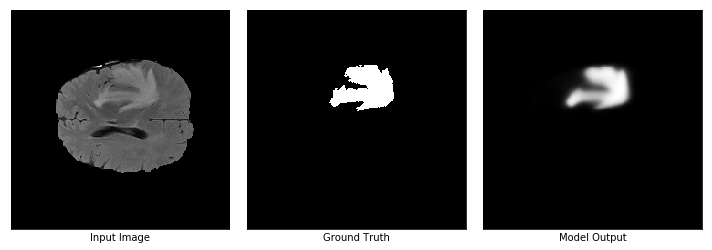

Steps: 1000, Loss:0.0060959309339523315, Dice Score:0.7699542045593262
Gradient min:-0.0015023277373984456, max:0.002158417133614421



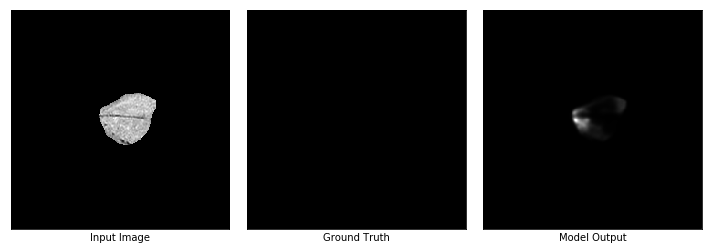

Steps: 2000, Loss:0.0064655630849301815, Dice Score:1.9656257066458238e-08
Gradient min:-0.00335329188965261, max:0.002037019468843937

Average Dice Coefficient: 0.6480095386505127
HGG_lbl_complete_tumor_HGG_training_MR_T1.tfrecords




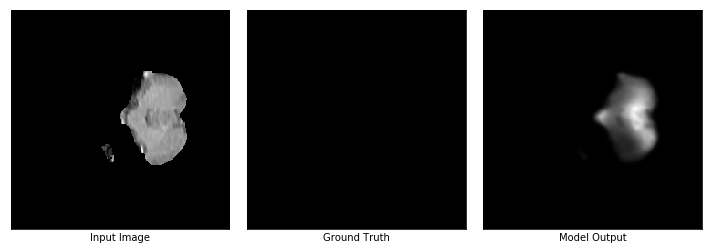

Steps: 3000, Loss:0.02405600994825363, Dice Score:6.973112309793805e-09
Gradient min:-0.008809907361865044, max:0.011470530182123184



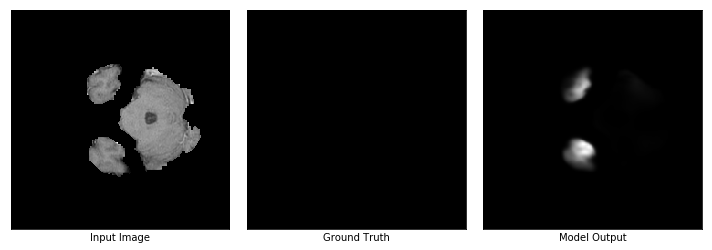

Steps: 4000, Loss:0.027467502281069756, Dice Score:1.7367352000974279e-09
Gradient min:-0.00549249118193984, max:0.01098537351936102

Average Dice Coefficient: 0.5719786882400513
HGG_lbl_complete_tumor_HGG_training_MR_T1c.tfrecords




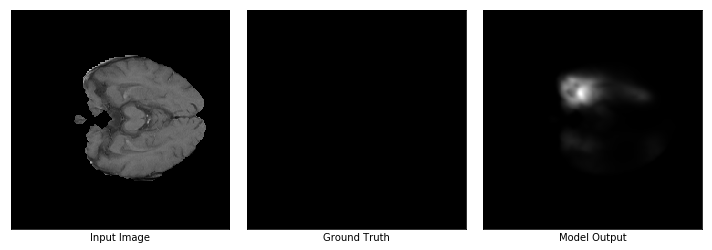

Steps: 5000, Loss:0.008599077351391315, Dice Score:5.829104421373188e-10
Gradient min:-0.004435457289218903, max:0.0018377389060333371



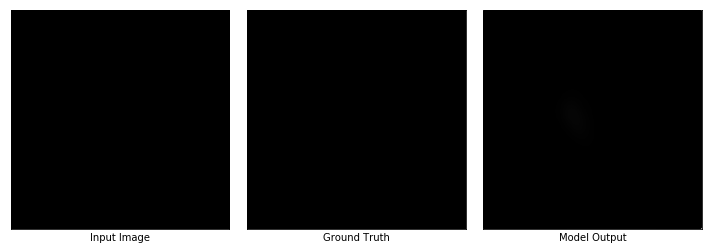

Steps: 6000, Loss:0.0069643305614590645, Dice Score:2.4127086817316012e-06
Gradient min:-0.0034318682737648487, max:0.004088199231773615

Average Dice Coefficient: 0.6206283569335938
HGG_lbl_complete_tumor_HGG_training_MR_T2.tfrecords




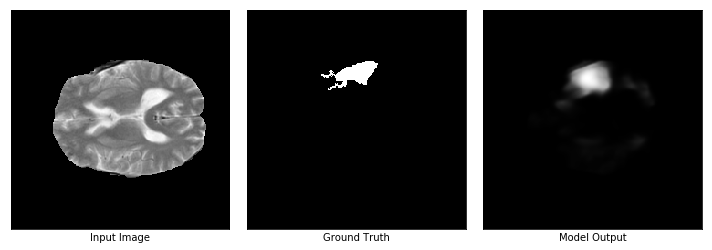

Steps: 7000, Loss:0.010347703471779823, Dice Score:0.4975857734680176
Gradient min:-0.002438749186694622, max:0.0032830366399139166



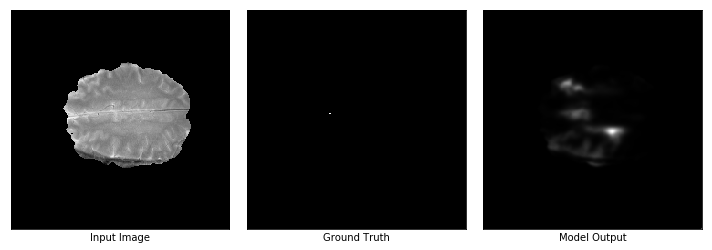

Steps: 8000, Loss:0.007090286817401648, Dice Score:0.0007928919512778521
Gradient min:-0.0037333390209823847, max:0.0017677602590993047

Average Dice Coefficient: 0.6606451869010925
Epochs  2

HGG_lbl_complete_tumor_HGG_training_MR_Flair.tfrecords




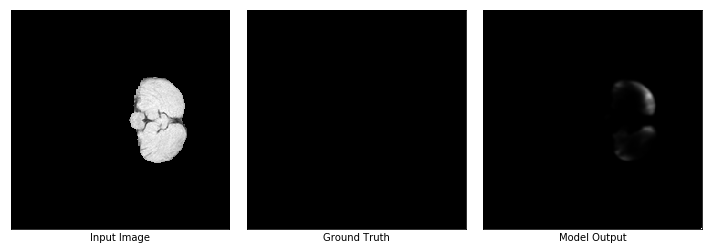

Steps: 1000, Loss:0.005171726457774639, Dice Score:1.1227310778849642e-06
Gradient min:-0.0012941646855324507, max:0.0026338978204876184



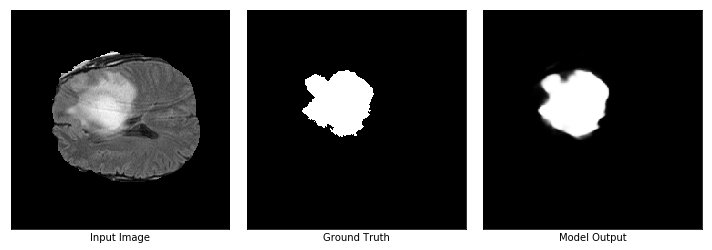

Steps: 2000, Loss:0.005679771304130554, Dice Score:0.9511313438415527
Gradient min:-0.00209571560844779, max:0.0024393186904489994

Average Dice Coefficient: 0.7003072500228882
HGG_lbl_complete_tumor_HGG_training_MR_T1.tfrecords




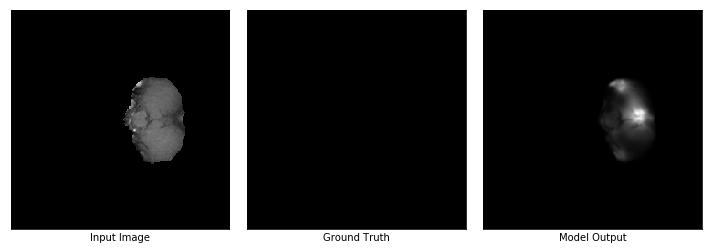

Steps: 3000, Loss:0.012526319362223148, Dice Score:3.672430537449145e-08
Gradient min:-0.008059646002948284, max:0.014176420867443085



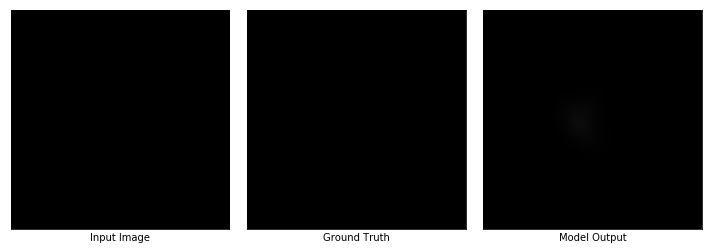

Steps: 4000, Loss:0.008883423171937466, Dice Score:0.0002258865861222148
Gradient min:-0.0018671073485165834, max:0.0020103715360164642

Average Dice Coefficient: 0.705752968788147
HGG_lbl_complete_tumor_HGG_training_MR_T1c.tfrecords




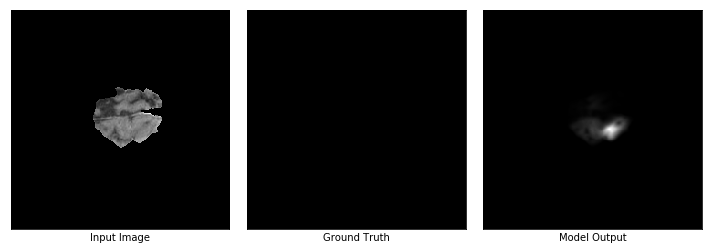

Steps: 5000, Loss:0.009064286947250366, Dice Score:4.51116521915651e-09
Gradient min:-0.0036307123955339193, max:0.0045308638364076614



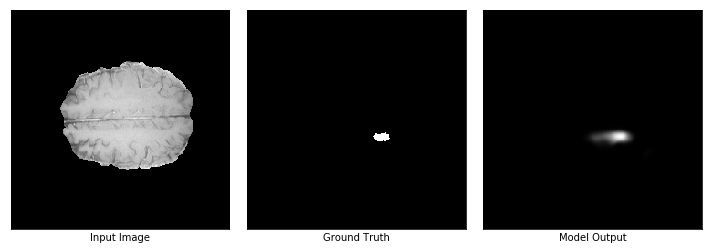

Steps: 6000, Loss:0.00647504348307848, Dice Score:0.4277837574481964
Gradient min:-0.003283717902377248, max:0.0015817254316061735

Average Dice Coefficient: 0.7214846611022949
HGG_lbl_complete_tumor_HGG_training_MR_T2.tfrecords




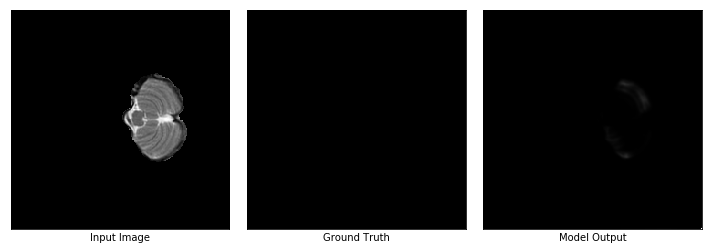

Steps: 7000, Loss:0.009530778042972088, Dice Score:3.522330871419399e-06
Gradient min:-0.004618900828063488, max:0.009183908812701702



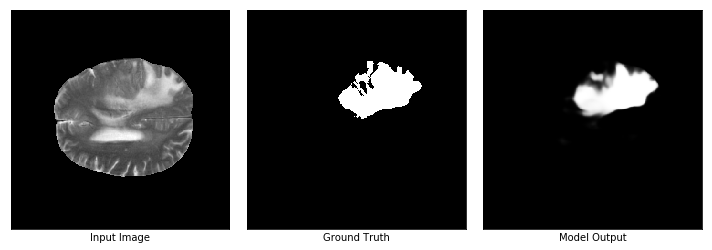

Steps: 8000, Loss:0.006642053835093975, Dice Score:0.8862382173538208
Gradient min:-0.001459341263398528, max:0.0012685341062024236

Average Dice Coefficient: 0.7369679808616638
Epochs  3

HGG_lbl_complete_tumor_HGG_training_MR_Flair.tfrecords




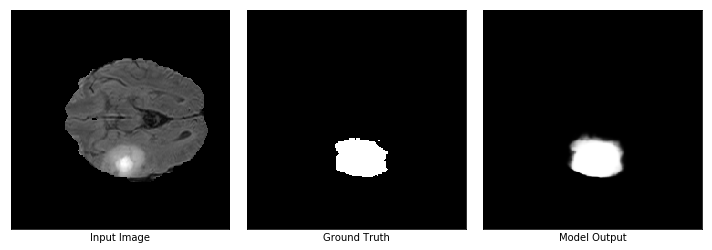

Steps: 1000, Loss:0.002720697084441781, Dice Score:0.9339072704315186
Gradient min:-0.0009945306228473783, max:0.0027558011934161186



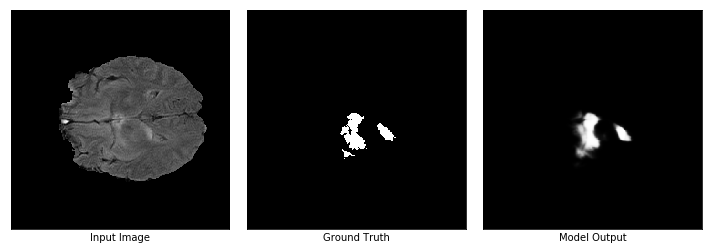

Steps: 2000, Loss:0.005413717124611139, Dice Score:0.7856926918029785
Gradient min:-0.001752920332364738, max:0.0008226072532124817

Average Dice Coefficient: 0.754023551940918
HGG_lbl_complete_tumor_HGG_training_MR_T1.tfrecords




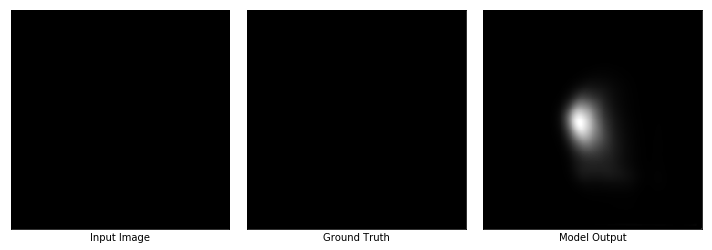

Steps: 3000, Loss:0.0036958365235477686, Dice Score:3.2900425139814615e-05
Gradient min:-0.002458472503349185, max:0.00264631281606853



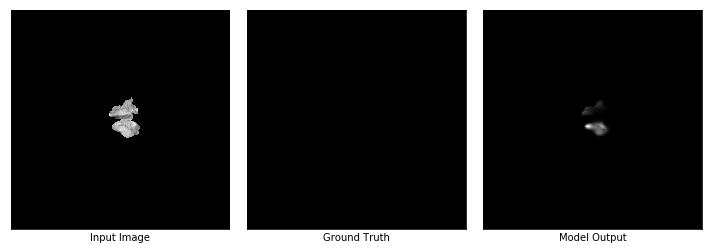

Steps: 4000, Loss:0.008197590708732605, Dice Score:2.3339875099281926e-07
Gradient min:-0.004748546052724123, max:0.0036728433333337307

Average Dice Coefficient: 0.7606807351112366
HGG_lbl_complete_tumor_HGG_training_MR_T1c.tfrecords




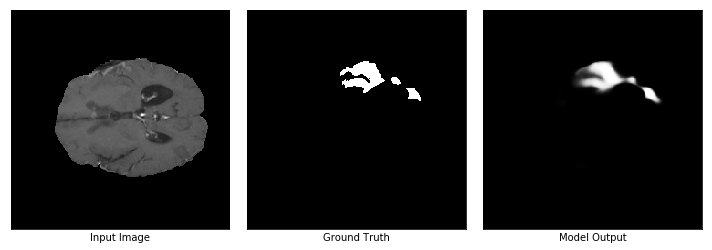

Steps: 5000, Loss:0.005121507681906223, Dice Score:0.7905526161193848
Gradient min:-0.003075881628319621, max:0.0025833393447101116



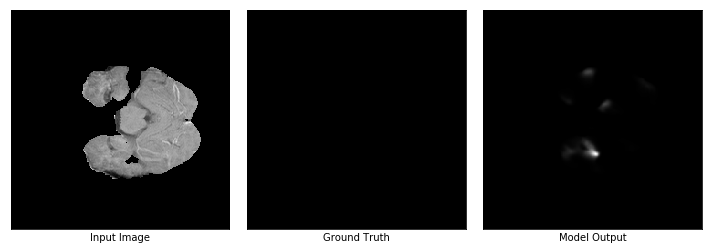

Steps: 6000, Loss:0.0033958163112401962, Dice Score:7.609767749272578e-08
Gradient min:-0.005872748792171478, max:0.003244338557124138

Average Dice Coefficient: 0.7699887156486511
HGG_lbl_complete_tumor_HGG_training_MR_T2.tfrecords




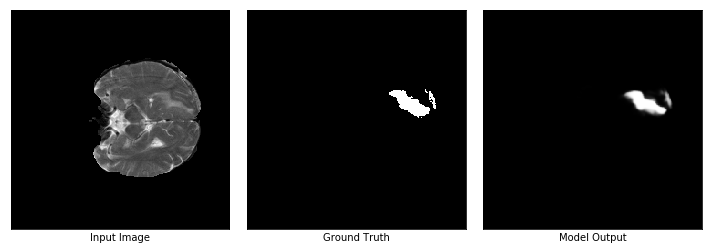

Steps: 7000, Loss:0.0035526014398783445, Dice Score:0.8184210062026978
Gradient min:-0.0005385830882005394, max:0.0005571174551732838



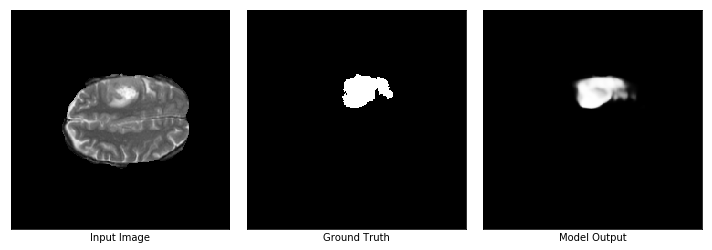

Steps: 8000, Loss:0.007554445415735245, Dice Score:0.8554727435112
Gradient min:-0.0017117296811193228, max:0.0029145064763724804

Average Dice Coefficient: 0.7789884805679321
Epochs  4

HGG_lbl_complete_tumor_HGG_training_MR_Flair.tfrecords




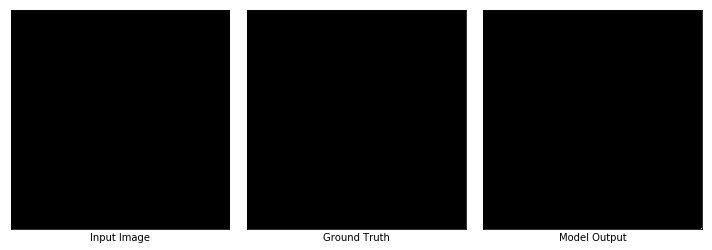

Steps: 1000, Loss:0.003841046243906021, Dice Score:0.00026090056053362787
Gradient min:-0.0014445269480347633, max:0.0009076239657588303



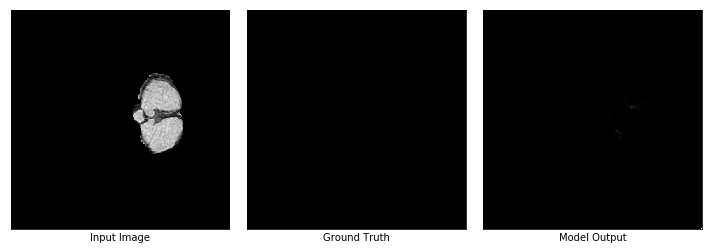

Steps: 2000, Loss:0.0037825738545507193, Dice Score:0.0007320361910387874
Gradient min:-0.0014065514551475644, max:0.0027879890985786915

Average Dice Coefficient: 0.7887336015701294
HGG_lbl_complete_tumor_HGG_training_MR_T1.tfrecords




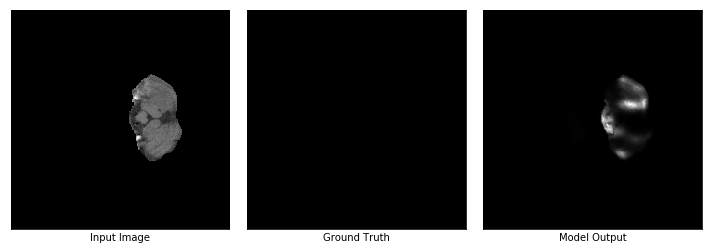

Steps: 3000, Loss:0.003354051848873496, Dice Score:5.162639808986569e-06
Gradient min:-0.0009657022310420871, max:0.0016611076425760984



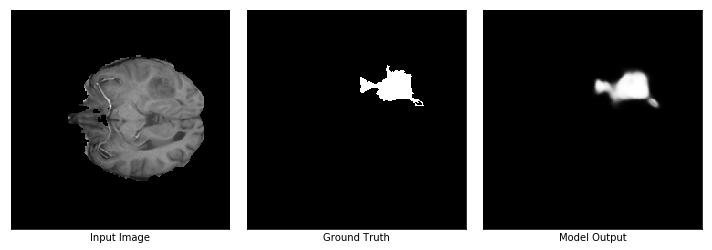

Steps: 4000, Loss:0.007936493493616581, Dice Score:0.828180730342865
Gradient min:-0.003340904600918293, max:0.0016302785370498896

Average Dice Coefficient: 0.7938475608825684
HGG_lbl_complete_tumor_HGG_training_MR_T1c.tfrecords




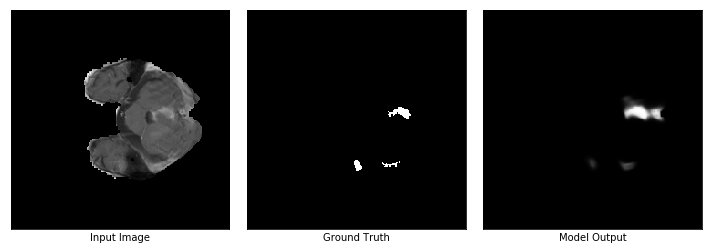

Steps: 5000, Loss:0.008302479982376099, Dice Score:0.453889936208725
Gradient min:-0.0033790082670748234, max:0.004042156506329775



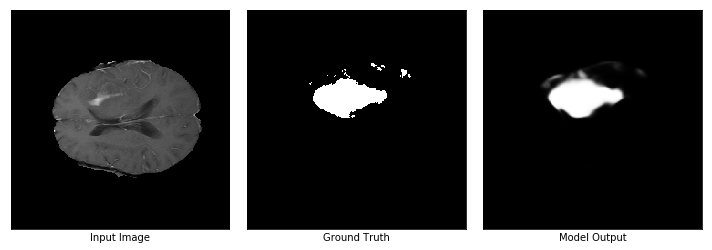

Steps: 6000, Loss:0.0061867376789450645, Dice Score:0.8869263529777527
Gradient min:-0.004700175020843744, max:0.0059090969152748585

Average Dice Coefficient: 0.7999408841133118
HGG_lbl_complete_tumor_HGG_training_MR_T2.tfrecords




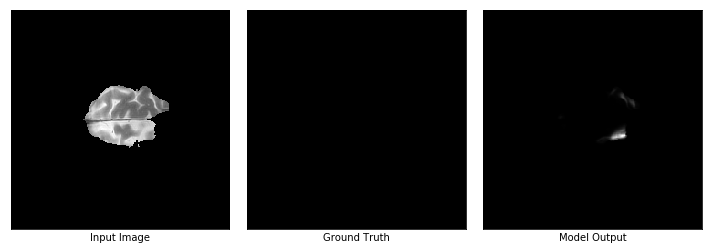

Steps: 7000, Loss:0.0031208461150527, Dice Score:1.9820781744783744e-06
Gradient min:-0.0012210328131914139, max:0.0009930047672241926



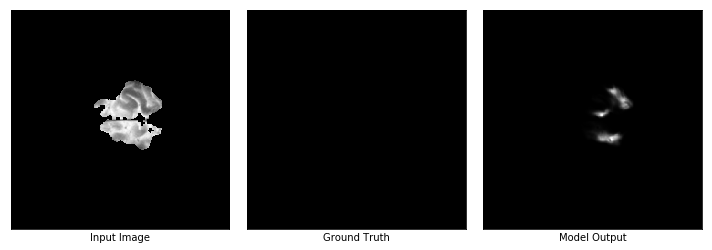

Steps: 8000, Loss:0.005108840297907591, Dice Score:3.6565008798561394e-08
Gradient min:-0.0017526996089145541, max:0.0011060292599722743

Average Dice Coefficient: 0.8059862852096558
Epochs  5

HGG_lbl_complete_tumor_HGG_training_MR_Flair.tfrecords




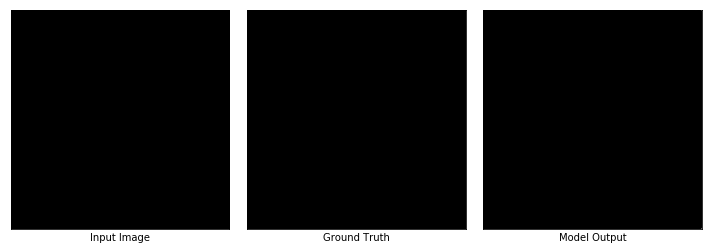

Steps: 1000, Loss:0.002926416927948594, Dice Score:0.0008182697929441929
Gradient min:-0.0009979774476960301, max:0.001434086705558002



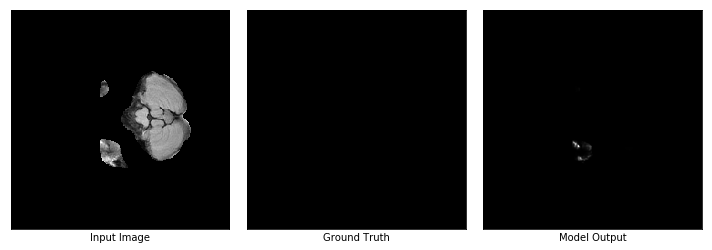

Steps: 2000, Loss:0.002551768673583865, Dice Score:3.2508835374756018e-06
Gradient min:-0.0010144207626581192, max:0.0012324257986620069

Average Dice Coefficient: 0.8126273155212402
HGG_lbl_complete_tumor_HGG_training_MR_T1.tfrecords




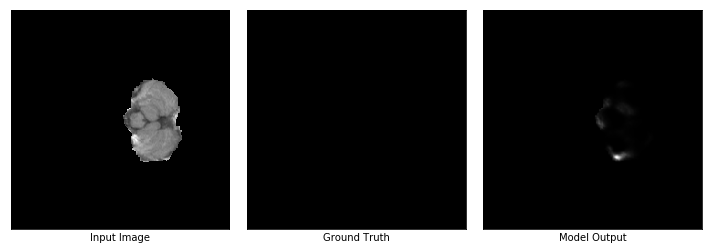

Steps: 3000, Loss:0.007835368625819683, Dice Score:1.6600799426669255e-05
Gradient min:-0.0015845545567572117, max:0.0027011835481971502



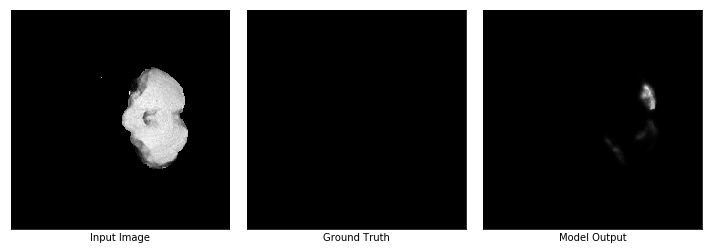

Steps: 4000, Loss:0.0030112271197140217, Dice Score:1.9775023247348145e-05
Gradient min:-0.0010333021637052298, max:0.0014359174529090524

Average Dice Coefficient: 0.8165345191955566
HGG_lbl_complete_tumor_HGG_training_MR_T1c.tfrecords




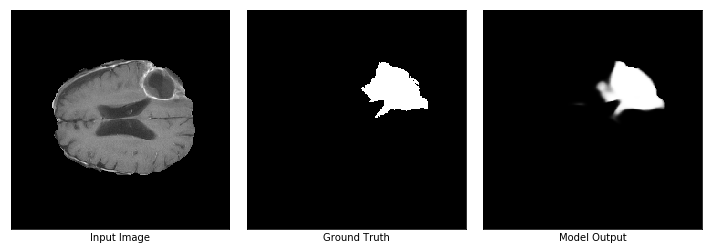

Steps: 5000, Loss:0.0030501720029860735, Dice Score:0.9363124370574951
Gradient min:-0.0008954317891038954, max:0.0014767347602173686



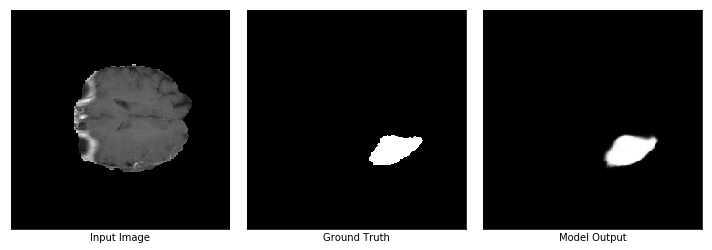

Steps: 6000, Loss:0.0020153147634118795, Dice Score:0.9306001663208008
Gradient min:-0.0015639931662008166, max:0.0017128292238339782

Average Dice Coefficient: 0.821047306060791
HGG_lbl_complete_tumor_HGG_training_MR_T2.tfrecords




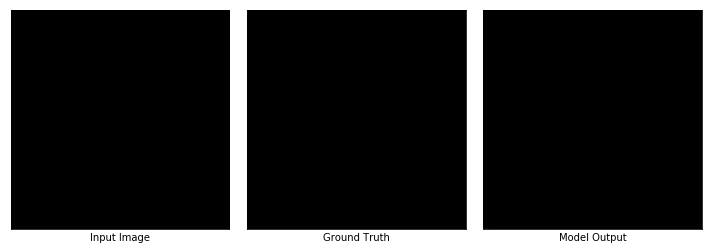

Steps: 7000, Loss:0.002074571792036295, Dice Score:0.00400781212374568
Gradient min:-0.0010348781943321228, max:0.0007962887757457793



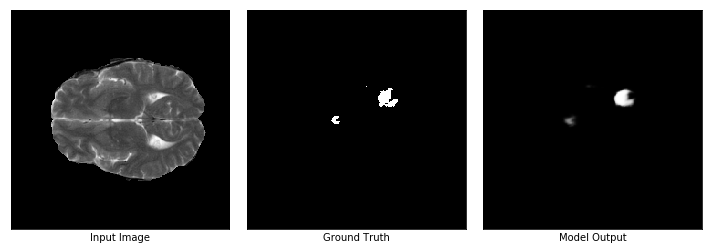

Steps: 8000, Loss:0.002071784809231758, Dice Score:0.756603479385376
Gradient min:-0.0006144269718788564, max:0.0009760648827068508

Average Dice Coefficient: 0.8253781795501709
Epochs  6

HGG_lbl_complete_tumor_HGG_training_MR_Flair.tfrecords




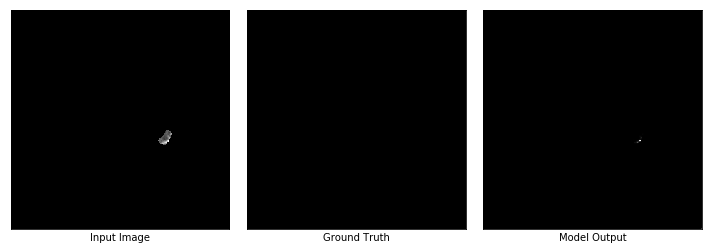

Steps: 1000, Loss:0.0026051721069961786, Dice Score:0.000444653385784477
Gradient min:-0.0021006595343351364, max:0.0011175458785146475



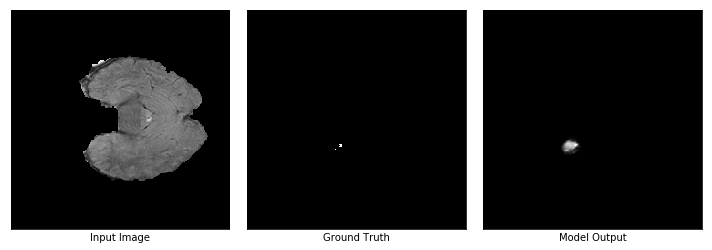

Steps: 2000, Loss:0.0023050138261169195, Dice Score:0.11295121163129807
Gradient min:-0.0014752649003639817, max:0.0005881941178813577

Average Dice Coefficient: 0.8301853537559509
HGG_lbl_complete_tumor_HGG_training_MR_T1.tfrecords




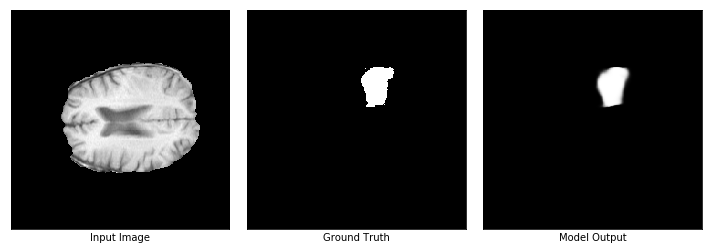

Steps: 3000, Loss:0.004013188183307648, Dice Score:0.9209050536155701
Gradient min:-0.001949743484146893, max:0.0022312754299491644



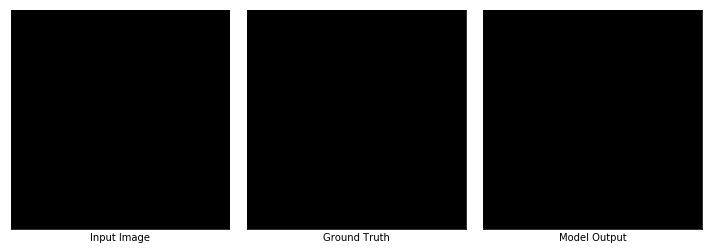

Steps: 4000, Loss:0.004304396919906139, Dice Score:0.07974981516599655
Gradient min:-0.001164967892691493, max:0.0016094903694465756

Average Dice Coefficient: 0.8332229852676392
HGG_lbl_complete_tumor_HGG_training_MR_T1c.tfrecords




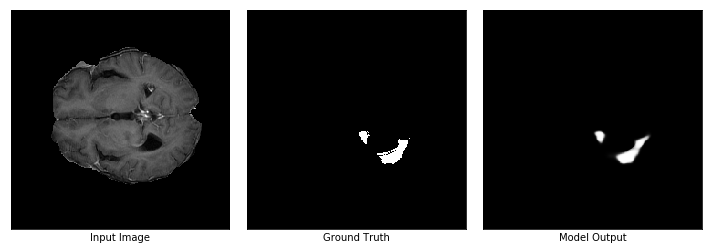

Steps: 5000, Loss:0.004239883739501238, Dice Score:0.8113566040992737
Gradient min:-0.00044568642624653876, max:0.0008400427759625018



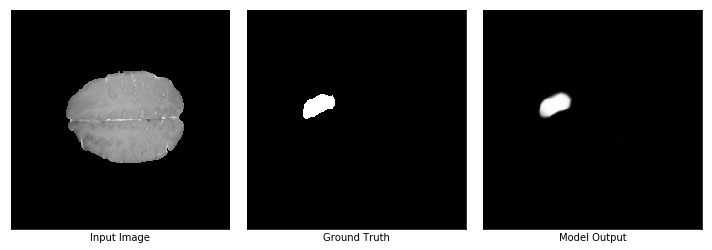

Steps: 6000, Loss:0.0058533260598778725, Dice Score:0.8985103964805603
Gradient min:-0.0010701402788981795, max:0.0011862656101584435

Average Dice Coefficient: 0.8367260694503784
HGG_lbl_complete_tumor_HGG_training_MR_T2.tfrecords




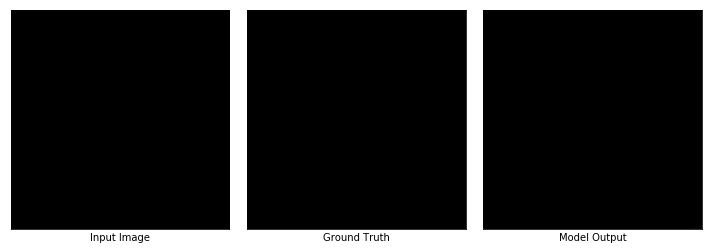

Steps: 7000, Loss:0.003398345550522208, Dice Score:0.003455245168879628
Gradient min:-0.0018408420728519559, max:0.0007564870757050812



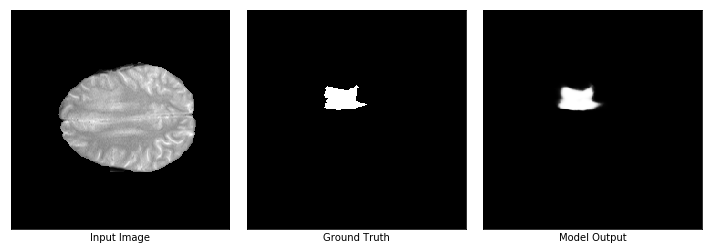

Steps: 8000, Loss:0.002071418333798647, Dice Score:0.905734658241272
Gradient min:-0.001594384666532278, max:0.0005697435699403286

Average Dice Coefficient: 0.8399807810783386
Epochs  7

HGG_lbl_complete_tumor_HGG_training_MR_Flair.tfrecords




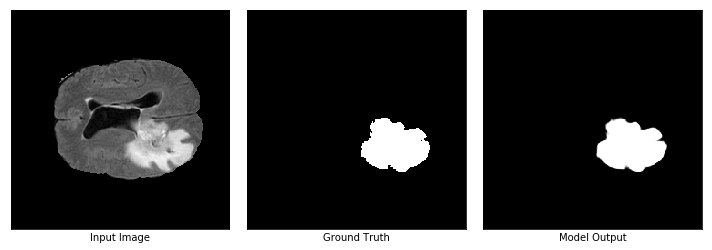

Steps: 1000, Loss:0.002132607391104102, Dice Score:0.9804304242134094
Gradient min:-0.00025146410916931927, max:0.000595754652749747



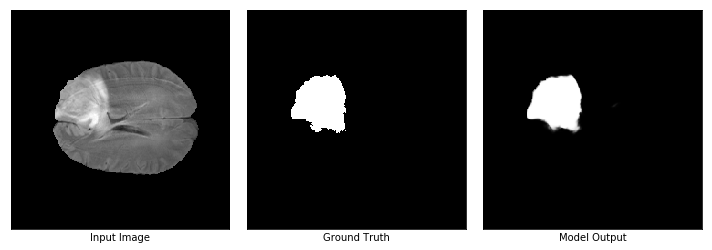

Steps: 2000, Loss:0.00400368869304657, Dice Score:0.9646051526069641
Gradient min:-0.0010837116278707981, max:0.002273671794682741

Average Dice Coefficient: 0.8436733484268188
HGG_lbl_complete_tumor_HGG_training_MR_T1.tfrecords




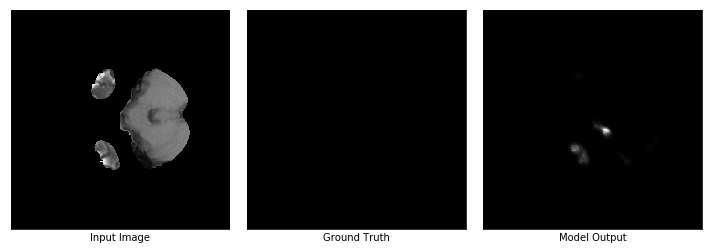

Steps: 3000, Loss:0.0023109919857233763, Dice Score:4.242875093041221e-06
Gradient min:-0.0005517908721230924, max:0.0011500836117193103



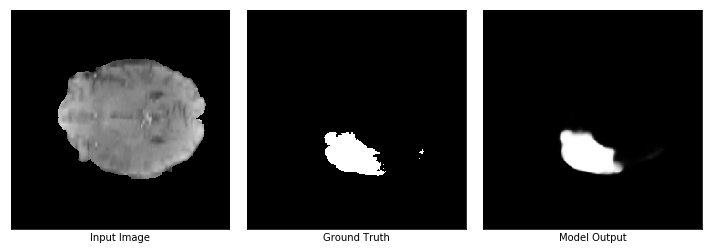

Steps: 4000, Loss:0.00295929703861475, Dice Score:0.9210239052772522
Gradient min:-0.0010999117512255907, max:0.0010011595441028476

Average Dice Coefficient: 0.8462346196174622
HGG_lbl_complete_tumor_HGG_training_MR_T1c.tfrecords




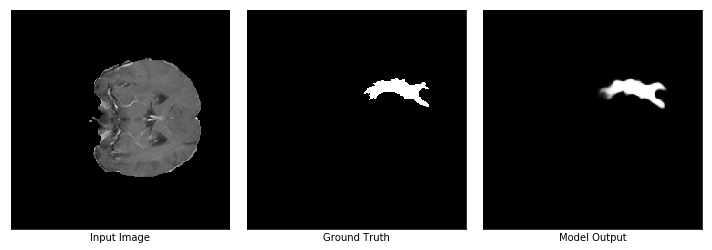

Steps: 5000, Loss:0.004041286185383797, Dice Score:0.8946979641914368
Gradient min:-0.0011149287456646562, max:0.001538180629722774



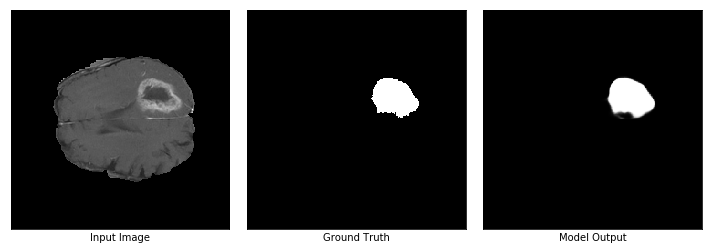

Steps: 6000, Loss:0.004358307458460331, Dice Score:0.9664139151573181
Gradient min:-0.0011816555634140968, max:0.0009492590324953198

Average Dice Coefficient: 0.8490055203437805
HGG_lbl_complete_tumor_HGG_training_MR_T2.tfrecords




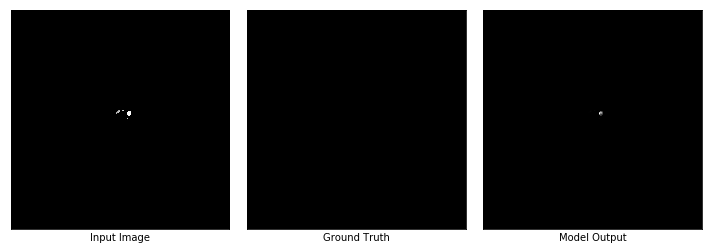

Steps: 7000, Loss:0.0026096762157976627, Dice Score:3.0083514502621256e-05
Gradient min:-0.0010432195849716663, max:0.0014944222057238221



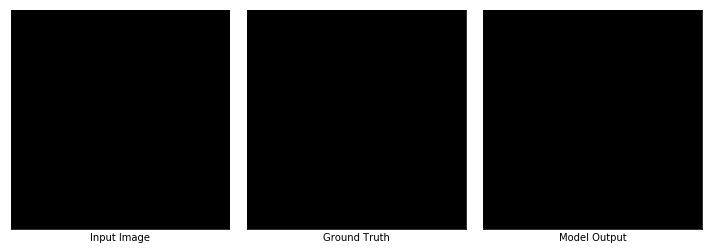

Steps: 8000, Loss:0.003421638859435916, Dice Score:0.017992639914155006
Gradient min:-0.0005452848854474723, max:0.0013191772159188986

Average Dice Coefficient: 0.8515793085098267
Epochs  8

HGG_lbl_complete_tumor_HGG_training_MR_Flair.tfrecords




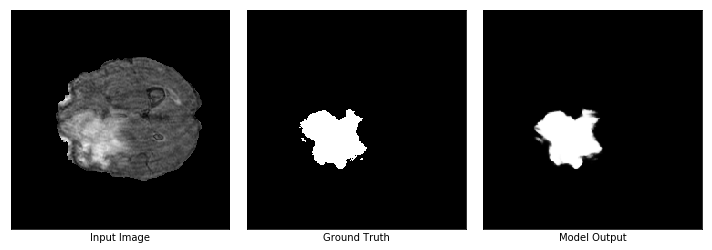

Steps: 1000, Loss:0.003394542494788766, Dice Score:0.9538615942001343
Gradient min:-0.0006175466696731746, max:0.0010989934671670198



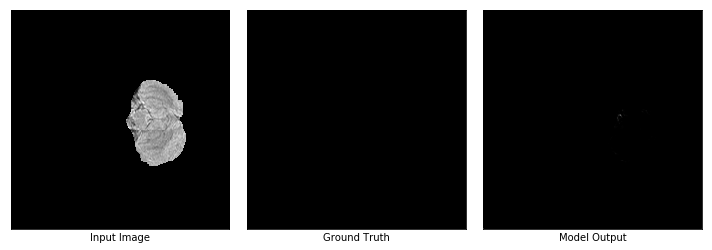

Steps: 2000, Loss:0.0023853410966694355, Dice Score:0.0028227493166923523
Gradient min:-0.0005366042605601251, max:0.0002368976711295545

Average Dice Coefficient: 0.8544960021972656
HGG_lbl_complete_tumor_HGG_training_MR_T1.tfrecords




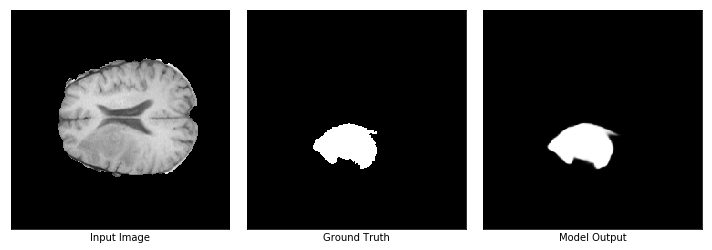

Steps: 3000, Loss:0.0014442121610045433, Dice Score:0.965039849281311
Gradient min:-0.00043092353735119104, max:0.0006507164798676968



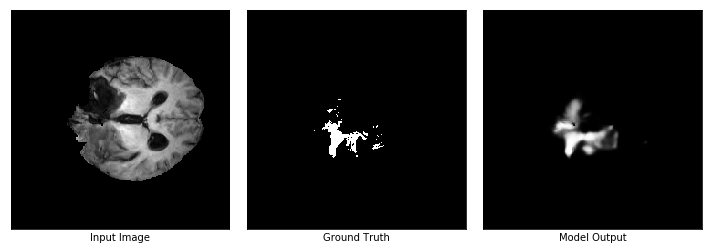

Steps: 4000, Loss:0.004000015556812286, Dice Score:0.5850946307182312
Gradient min:-0.0006660615908913314, max:0.000780699891038239

Average Dice Coefficient: 0.8566082715988159
HGG_lbl_complete_tumor_HGG_training_MR_T1c.tfrecords




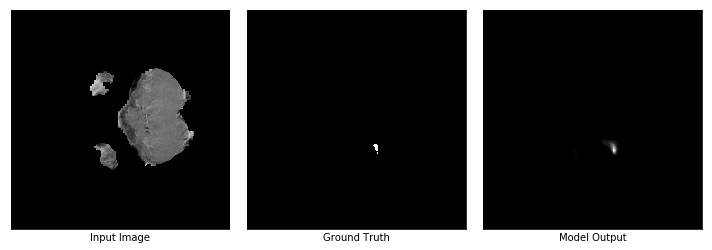

Steps: 5000, Loss:0.001111127552576363, Dice Score:0.2974969744682312
Gradient min:-0.0004914178280159831, max:0.0007511833682656288



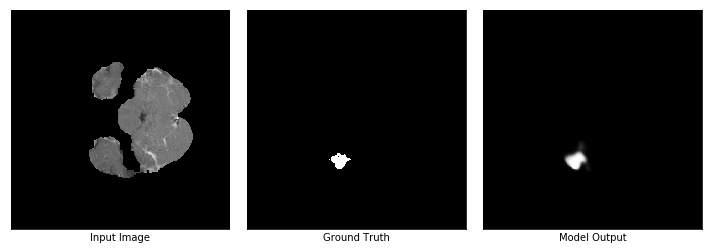

Steps: 6000, Loss:0.00251021352596581, Dice Score:0.7780545353889465
Gradient min:-0.0007106206612661481, max:0.0016221774276345968

Average Dice Coefficient: 0.8588574528694153
HGG_lbl_complete_tumor_HGG_training_MR_T2.tfrecords




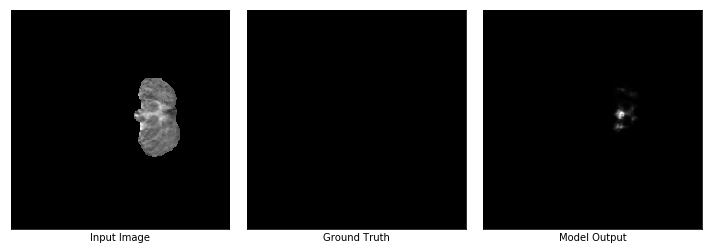

Steps: 7000, Loss:0.0016641041729599237, Dice Score:1.0976531257256283e-06
Gradient min:-0.00022403504408430308, max:0.0002575019607320428



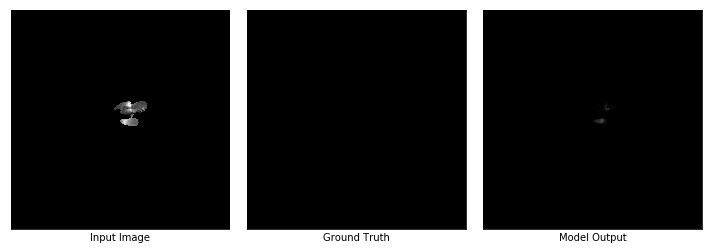

Steps: 8000, Loss:0.0014393444871529937, Dice Score:0.00010909838601946831
Gradient min:-0.0006064027547836304, max:0.0005633648252114654

Average Dice Coefficient: 0.860980212688446
Epochs  9

HGG_lbl_complete_tumor_HGG_training_MR_Flair.tfrecords




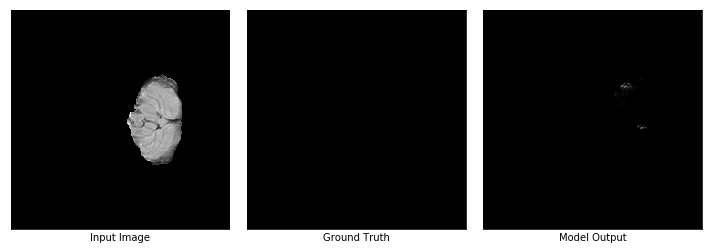

Steps: 1000, Loss:0.0025710267946124077, Dice Score:0.00014835716865491122
Gradient min:-0.000343476131092757, max:0.000380167766707018



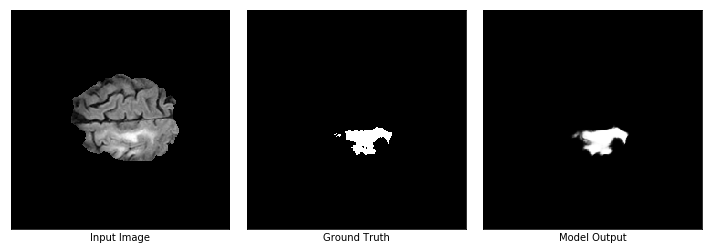

Steps: 2000, Loss:0.0018765464192256331, Dice Score:0.9023341536521912
Gradient min:-0.0005920282565057278, max:0.0004828794044442475

Average Dice Coefficient: 0.8633753061294556
HGG_lbl_complete_tumor_HGG_training_MR_T1.tfrecords




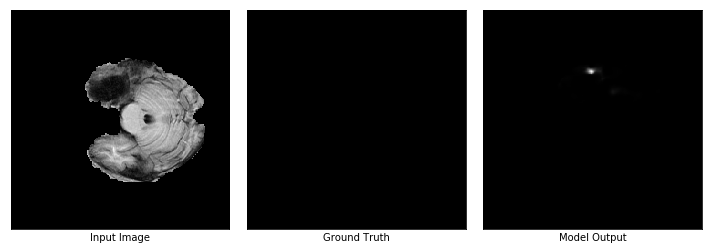

Steps: 3000, Loss:0.003061623079702258, Dice Score:3.9691041564537954e-08
Gradient min:-0.0010071101132780313, max:0.001191241666674614



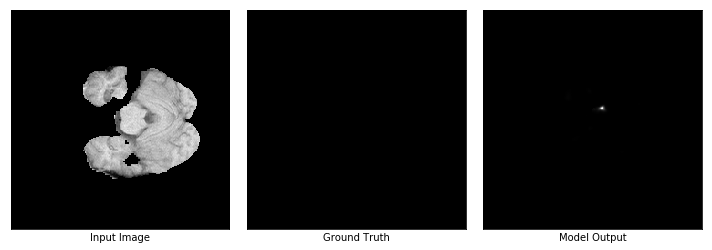

Steps: 4000, Loss:0.0024201474152505398, Dice Score:4.877122592006344e-06
Gradient min:-0.0006281886016950011, max:0.0005116095417179167

Average Dice Coefficient: 0.8651601672172546
HGG_lbl_complete_tumor_HGG_training_MR_T1c.tfrecords




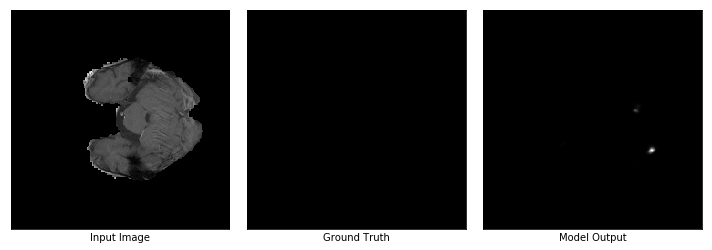

Steps: 5000, Loss:0.0023687751963734627, Dice Score:3.3177941531903343e-06
Gradient min:-0.0005574794486165047, max:0.0007940396317280829



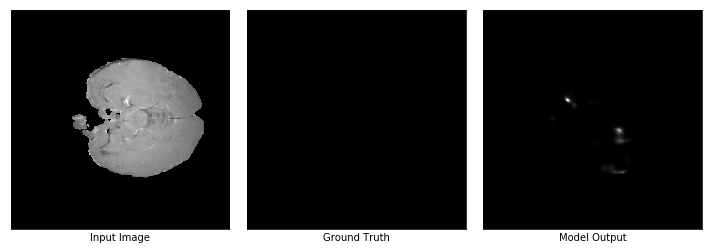

Steps: 6000, Loss:0.0024638602044433355, Dice Score:1.869573793555901e-07
Gradient min:-0.0004194167267996818, max:0.0003571715496946126

Average Dice Coefficient: 0.8670598268508911
HGG_lbl_complete_tumor_HGG_training_MR_T2.tfrecords




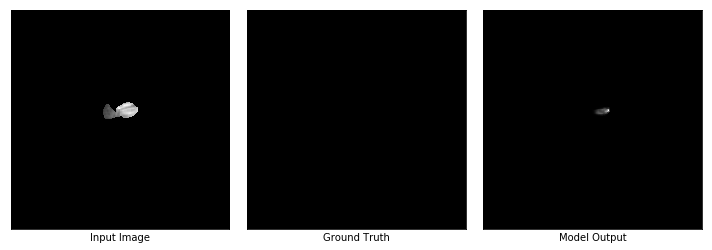

Steps: 7000, Loss:0.002255416475236416, Dice Score:4.887282102572499e-06
Gradient min:-0.001619645394384861, max:0.0007016264135017991



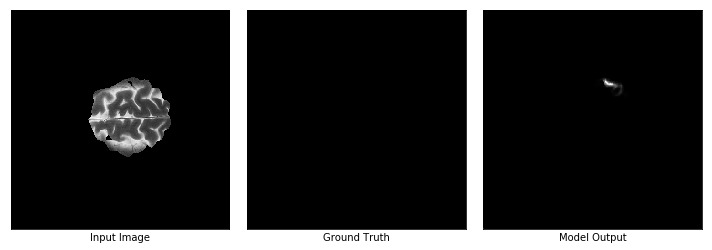

Steps: 8000, Loss:0.0031060760375112295, Dice Score:2.404026236035861e-05
Gradient min:-0.0013618126977235079, max:0.0010763579048216343

Average Dice Coefficient: 0.8688248991966248
Epochs 10

HGG_lbl_complete_tumor_HGG_training_MR_Flair.tfrecords




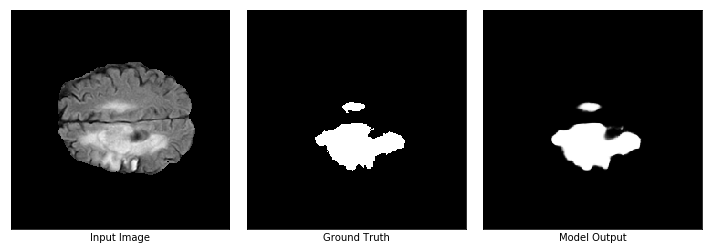

Steps: 1000, Loss:0.0020291220862418413, Dice Score:0.9593625664710999
Gradient min:-0.0006843701703473926, max:0.0007560522062703967



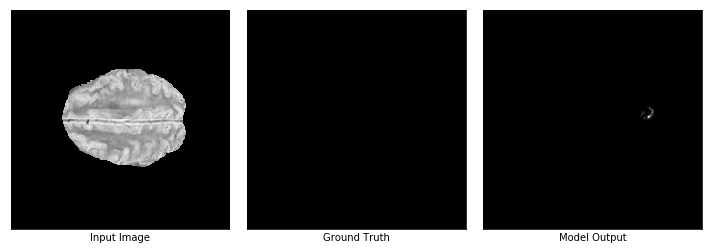

Steps: 2000, Loss:0.001464774482883513, Dice Score:4.615529576312838e-07
Gradient min:-0.00034250682801939547, max:0.00038287340430542827

Average Dice Coefficient: 0.8707858324050903
HGG_lbl_complete_tumor_HGG_training_MR_T1.tfrecords




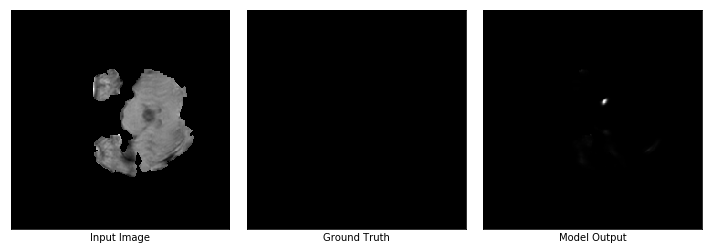

Steps: 3000, Loss:0.001913755782879889, Dice Score:1.7167343457913375e-06
Gradient min:-0.00035824000951834023, max:0.00047212844947353005



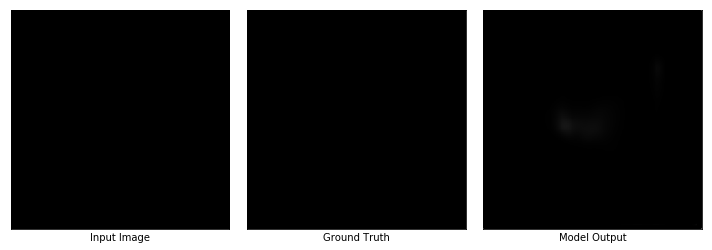

Steps: 4000, Loss:0.0038331043906509876, Dice Score:0.7306059002876282
Gradient min:-0.0023539061658084393, max:0.0010994223412126303

Average Dice Coefficient: 0.8723046183586121
HGG_lbl_complete_tumor_HGG_training_MR_T1c.tfrecords




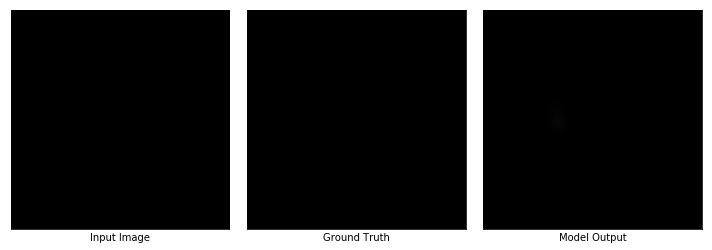

Steps: 5000, Loss:0.0031533148139715195, Dice Score:0.9899775981903076
Gradient min:-0.0004024324007332325, max:0.0008491760236211121



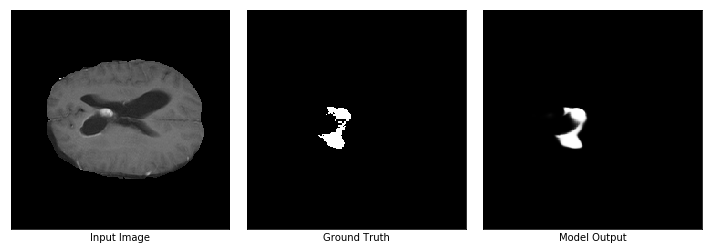

Steps: 6000, Loss:0.0026502031832933426, Dice Score:0.8598402738571167
Gradient min:-0.0005800161743536592, max:0.0011587155750021338

Average Dice Coefficient: 0.8739072680473328
HGG_lbl_complete_tumor_HGG_training_MR_T2.tfrecords




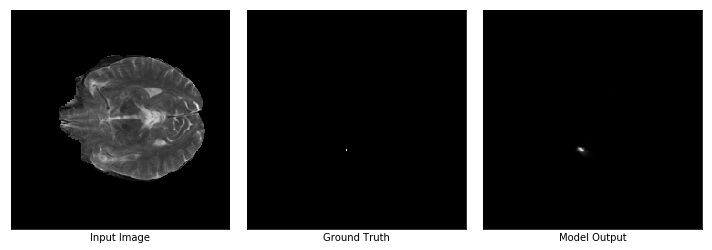

Steps: 7000, Loss:0.002700452459976077, Dice Score:0.03287848085165024
Gradient min:-0.0007413288694806397, max:0.0010445737279951572



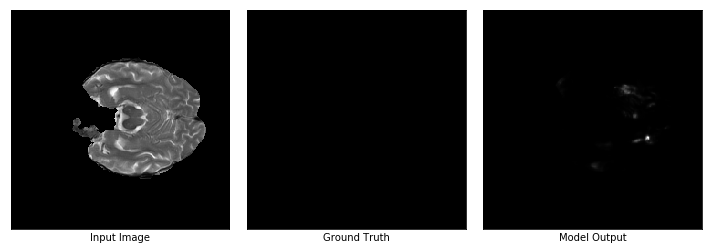

Steps: 8000, Loss:0.002185992430895567, Dice Score:4.600768988893833e-06
Gradient min:-0.0003493844997137785, max:0.0004966887645423412

Average Dice Coefficient: 0.8753989338874817
Epochs 11

HGG_lbl_complete_tumor_HGG_training_MR_Flair.tfrecords




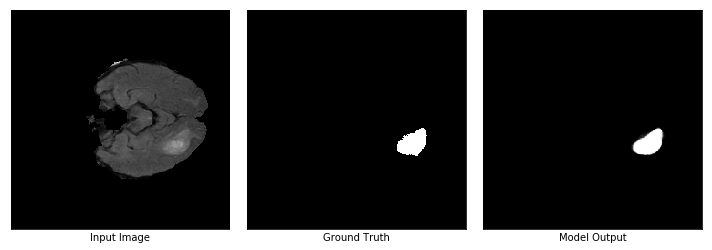

Steps: 1000, Loss:0.002348545705899596, Dice Score:0.9389739036560059
Gradient min:-0.0007984068361110985, max:0.0009068705257959664



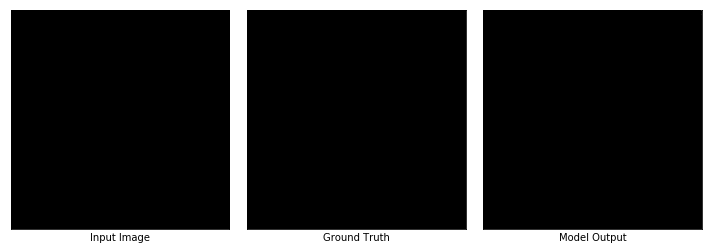

Steps: 2000, Loss:0.0014525324804708362, Dice Score:0.254659503698349
Gradient min:-0.00041581978439353406, max:0.00041706248885020614

Average Dice Coefficient: 0.8771045207977295
HGG_lbl_complete_tumor_HGG_training_MR_T1.tfrecords




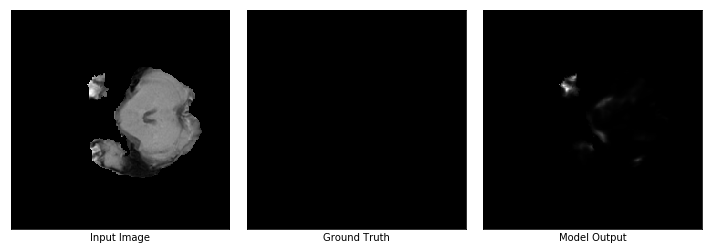

Steps: 3000, Loss:0.0017595647368580103, Dice Score:6.052366188669112e-06
Gradient min:-0.0007224533474072814, max:0.0003991065896116197



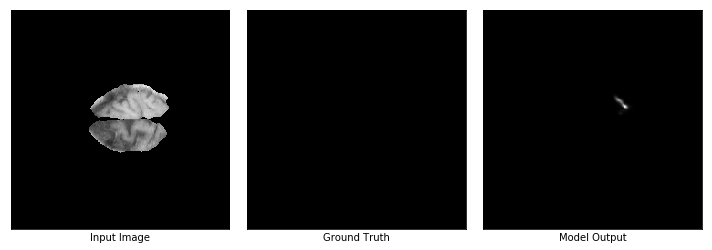

Steps: 4000, Loss:0.0019243790302425623, Dice Score:1.6170940142501422e-08
Gradient min:-0.000569566385820508, max:0.0004414611612446606

Average Dice Coefficient: 0.8784189820289612
HGG_lbl_complete_tumor_HGG_training_MR_T1c.tfrecords




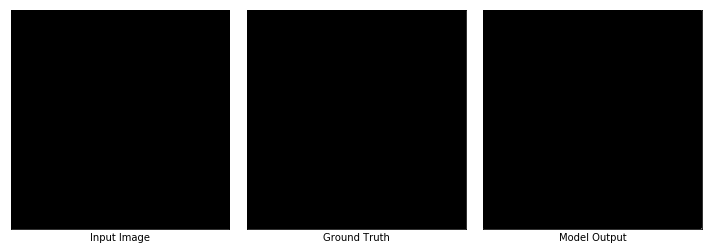

Steps: 5000, Loss:0.003412611549720168, Dice Score:0.7595200538635254
Gradient min:-0.0010262173600494862, max:0.0007436689338646829



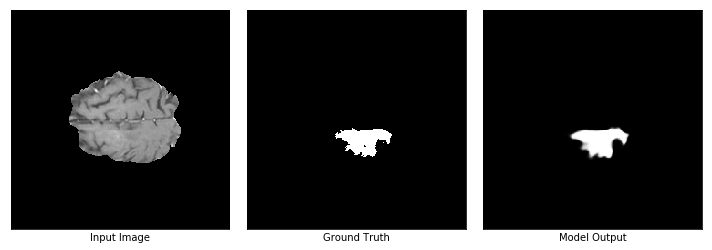

Steps: 6000, Loss:0.003336493158712983, Dice Score:0.925265371799469
Gradient min:-0.0007598255178891122, max:0.0006172475405037403

Average Dice Coefficient: 0.879816472530365
HGG_lbl_complete_tumor_HGG_training_MR_T2.tfrecords




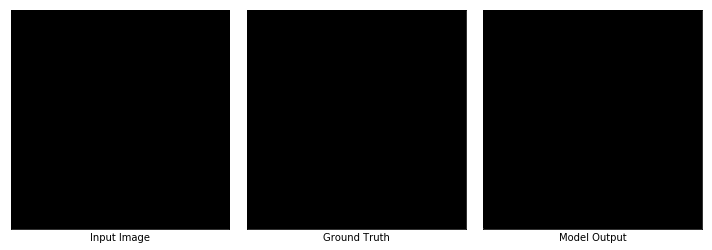

Steps: 7000, Loss:0.0013514591846615076, Dice Score:0.013809005729854107
Gradient min:-0.0005364110693335533, max:0.000594808254390955



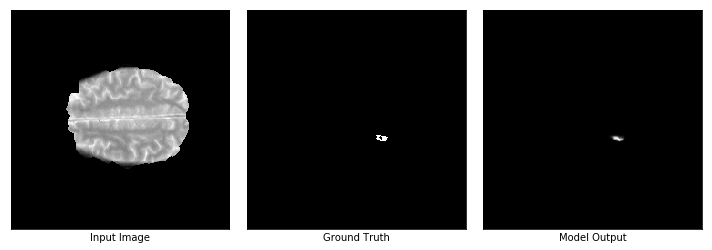

Steps: 8000, Loss:0.0020036003552377224, Dice Score:0.41249600052833557
Gradient min:-0.00031465443316847086, max:0.0007447691750712693

Average Dice Coefficient: 0.881128191947937
Epochs 12

HGG_lbl_complete_tumor_HGG_training_MR_Flair.tfrecords




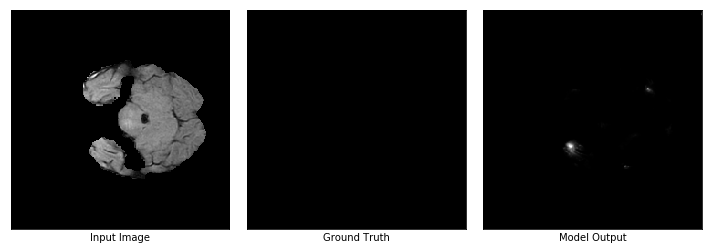

Steps: 1000, Loss:0.0025528580881655216, Dice Score:5.906496767238423e-07
Gradient min:-0.0006448311032727361, max:0.0009620643686503172



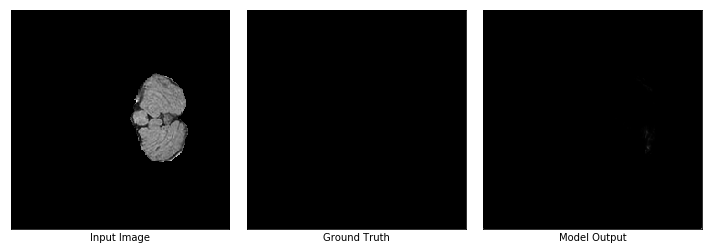

Steps: 2000, Loss:0.0020077514927834272, Dice Score:0.053376197814941406
Gradient min:-0.0006047154311090708, max:0.0003264464030507952

Average Dice Coefficient: 0.882603645324707
HGG_lbl_complete_tumor_HGG_training_MR_T1.tfrecords




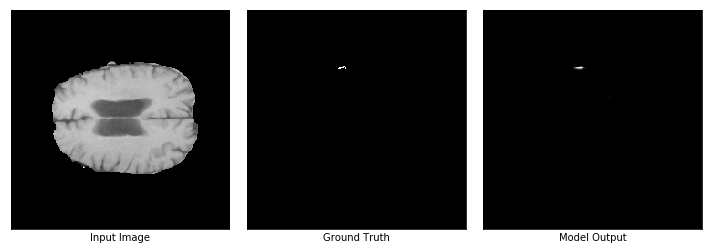

Steps: 3000, Loss:0.0030339520890265703, Dice Score:0.5215836763381958
Gradient min:-0.0004623119893949479, max:0.0005380765651352704



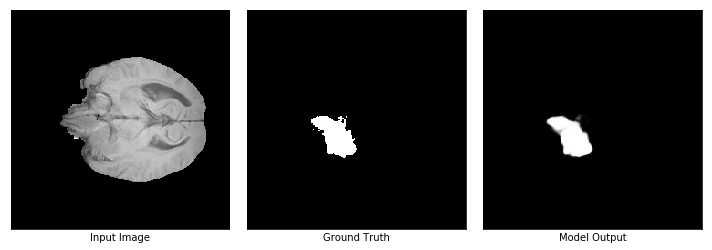

Steps: 4000, Loss:0.003266346175223589, Dice Score:0.9330180883407593
Gradient min:-0.0008223348413594067, max:0.0009205691749230027

Average Dice Coefficient: 0.8837608098983765
HGG_lbl_complete_tumor_HGG_training_MR_T1c.tfrecords




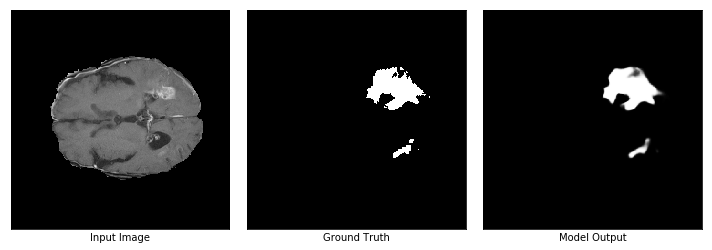

Steps: 5000, Loss:0.0026159053668379784, Dice Score:0.9239463210105896
Gradient min:-0.00042023579590022564, max:0.0007583359838463366



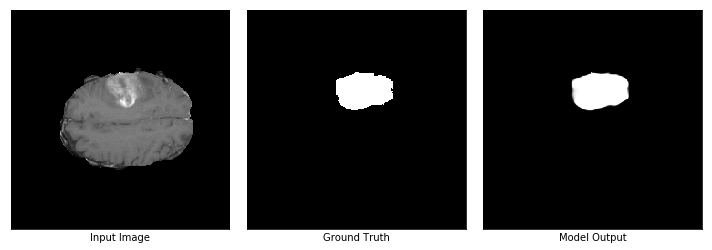

Steps: 6000, Loss:0.0019970531575381756, Dice Score:0.9742919206619263
Gradient min:-0.0012497695861384273, max:0.0013054546434432268

Average Dice Coefficient: 0.8849819302558899
HGG_lbl_complete_tumor_HGG_training_MR_T2.tfrecords



DataLossError: corrupted record at 4123690206

In [7]:
epochs = 1
max_epochs = 20
predicted_img = []
groundtruth_img = []
loss_list = []
dice_list = []
while epochs <= max_epochs:
    print("Epochs {:2d}".format(epochs))
    print()
    steps = 1
    for tf_re in sorted(os.listdir(tfrecords_read_dir)):
        print(tf_re)
        print()
        tf_dir = os.path.join(tfrecords_read_dir+tf_re)
        dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        for image, label in dataset:
            image = tf.reshape(image, [-1, 240, 240, 1]) #(batch_size, img_size, img_size, channel)
            label = tf.reshape(label, [-1, 240, 240, 1]) #(batch_size, img_size, img_size, channel)
            img_seg, loss, gradients = train_fn(image, label) #training function 
            dice_score = dice_coef(label, img_seg)
            
            dice_list.append(dice_score) #append dice score for every every images
            
            #output
            if steps%1000==0:
                input_img = [image[0], label[0], img_seg[0]]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3)
                
                predicted_img.append(img_seg[0])
                groundtruth_img.append(label[0])
                loss_list.append(loss)
                dice_coe = dice_coef(label[0], img_seg[0])
                print("Steps: {}, Loss:{}, Dice Score:{}".format(steps, loss, dice_coe))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
        print()
        print("Average Dice Coefficient: {}".format(np.mean(np.array(dice_list))))
    epochs+=1 

---

# Model Summary

In [ ]:
# Unet.summary()